In [4]:
import pandas as pd
import sklearn
from sklearn import preprocessing
import datetime
from boruta import BorutaPy
import math
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
from sklearn.model_selection import train_test_split

In [5]:
# Functions for Feature Generation for Time Series Data
le_day_of_week = preprocessing.LabelEncoder()
le_week_status = preprocessing.LabelEncoder()

def secondsDay(data_frame):
    hour = data_frame.date.dt.hour
    minute = data_frame.date.dt.minute
    seconds = data_frame.date.dt.second
    return hour * 3600 + minute * 60 + seconds
    
def weekStatus(data_frame, label_encoder):
    week_status_DF = pd.DataFrame(columns=['week_status'])
    train_date_DF = pd.DataFrame(columns=['date'])
    train_date_DF = data_frame['date']    
    for date in train_date_DF.items():
        day = date[1].weekday_name
        if day == 'Saturday' or day == 'Sunday':
            week_status_DF =  week_status_DF.append({'week_status': 'Weekend'}, ignore_index=True)
        else:
            week_status_DF =  week_status_DF.append({'week_status': 'Weekday'}, ignore_index=True)
    
    weekstatus_labels = label_encoder.fit_transform(week_status_DF.values.ravel())
    return weekstatus_labels

def dayOfWeek(data_frame, label_encoder):
    day_of_week_label = label_encoder.fit_transform(data_frame.date.dt.weekday_name.values.ravel())
    return day_of_week_label

In [6]:
# Pre-process data
train_data = pd.read_csv('s3://ml-assignment2-data/UCI-electricity/UCI_data.csv', parse_dates=True)

# Generate timeseries eatures for complete dataset
train_data['date'] = train_data['date'].astype('datetime64[ns]')

# Feature Generation for Timeseries Data
# Generate Number of Seconds from Midnight (NSM), 
nsm_series = secondsDay(train_data)
nsm_DF = nsm_series.to_frame()

# Week Status of the data, weekend or weekday
week_status_DF = pd.DataFrame(data=weekStatus(train_data, le_week_status), columns=['week_status'])

# DayOfTheWeek, for each data row
day_of_week_DF = pd.DataFrame(data=dayOfWeek(train_data, le_day_of_week), columns=['day_of_week'])

train_data['nsm'] = nsm_DF['date']
train_data['week_status'] = week_status_DF['week_status']
train_data['day_of_week'] = day_of_week_DF['day_of_week']
train_data =  train_data.drop(columns=['date'])

In [7]:
# SKLEARN to create data partition function, 75% Training, 25% Testing. 
x_train_DF = train_data.drop(columns=['TARGET_energy'])
y_train_DF = pd.DataFrame(train_data['TARGET_energy'], columns=['TARGET_energy'])
print(type(y_train_DF))
print(type(x_train_DF))
x_train_values = x_train_DF.to_numpy().astype('float64')
y_train_values = y_train_DF.to_numpy().astype('float64')

X_train, X_test, y_train, y_test = train_test_split(x_train_values, y_train_values, test_size=.25, random_state=42)

<class 'pandas.core.frame.DataFrame'>
<class 'pandas.core.frame.DataFrame'>


In [8]:
independent_scaler = preprocessing.StandardScaler()
target_scaler = preprocessing.StandardScaler()

x_train_scaled = independent_scaler.fit_transform(X_train)
y_train_scaled = target_scaler.fit_transform(y_train.reshape(-1, 1))

X_train_scaled_DF = pd.DataFrame(x_train_scaled, columns=x_train_DF.columns)
Y_train_scaled_DF = pd.DataFrame(y_train_scaled, columns=y_train_DF.columns)

In [9]:
# Model & Feature Selection
from sklearn.model_selection import cross_validate
from sklearn.model_selection import cross_val_score
from sklearn.feature_selection import RFECV
from sklearn.model_selection import KFold

# Import Models Single (LR, SVM, ANN, DT)
from sklearn.svm import SVR
from sklearn import tree
from sklearn.linear_model import LinearRegression
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import BaggingRegressor
from sklearn.ensemble import VotingRegressor

# Import Models Ensemble (Boosting {Gradient Boosting Machines}, Averaging Methods {Voting and Bagging})
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.ensemble  import RandomForestRegressor

In [10]:
rf = RandomForestRegressor(n_estimators=20, criterion='mse')

feat_selector = RFECV(estimator=rf, step=1, cv=KFold(2))
feat_selector.fit(X_train_scaled_DF.to_numpy(), Y_train_scaled_DF.to_numpy().ravel())
feat_selector.support_

array([ True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True,  True,  True,  True,  True,  True,  True,  True,
        True,  True])

In [11]:
feat_selector.ranking_

array([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 1, 1])

In [12]:
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_weighted',
 'v_measure_score']

In [86]:
ann = MLPRegressor(random_state=0, activation='logistic', solver='sgd', tol=15000, max_iter=500)
lm = LinearRegression()
svr = SVR()
dt = tree.DecisionTreeRegressor()

gmb = GradientBoostingRegressor(random_state=0, n_estimators=10000, max_depth=5)
rfg = RandomForestRegressor(random_state=0)

r2 = 'r2'
mse = 'neg_mean_squared_error'
mae = 'neg_mean_absolute_error'

scoring = {}
scoring['r2'] =  r2
scoring['mse'] = mse
scoring['mae'] = mae

In [87]:
# Train Models for Single Methods
single_models = []
single_models.append(('LM', lm))
single_models.append(('SVR', svr))
single_models.append(('ANN', ann))
single_models.append(('DT', dt))

# Train Models for Ensemble Methods
ensemble_models = []
ensemble_models.append(('GMB', gmb))
ensemble_models.append(('RFG', rfg))

In [15]:
# Performance plotting
import matplotlib.pyplot as plt

def cross_validate_score(models, scoring_type):
    results = []
    names = []
    score = {}
    if scoring_type == 'rmse':
        for name, model in models:
            kfold = KFold(n_splits=10, random_state=4)
            cv_results= cross_val_score(model, X_train_scaled_DF.to_numpy(), Y_train_scaled_DF.to_numpy().ravel(), cv=kfold, scoring = scoring['mse'])
            results.append(cv_results)
            names.append(name)
            rmse = math.sqrt(-cv_results.mean())
            score[name] = cv_results
            msg = "%s: %s: %f (%f)" % (scoring_type, name, rmse, cv_results.std())
            print(msg)
    else:
        for name, model in models:
            kfold = KFold(n_splits=10, random_state=4)
            cv_results= cross_val_score(model, X_train_scaled_DF.to_numpy(), Y_train_scaled_DF.to_numpy().ravel(), cv=kfold, scoring = scoring[scoring_type])
            results.append(cv_results)
            names.append(name)
            score[name] = cv_results
            msg = "%s: %s: %f (%f)" % (scoring_type, name, cv_results.mean(), cv_results.std())
            print(msg)
    return score

def cross_validate_score_test(models, scoring_type, X_test_data, Y_test_data):
    results = []
    names = []
    score = {}
    if scoring_type == 'rmse':
        for name, model in models:
            kfold = KFold(n_splits=10, random_state=4)
            cv_results= cross_val_score(model, X_test_data.to_numpy(), Y_test_data.to_numpy().ravel(), cv=kfold, scoring = scoring['mse'])
            results.append(cv_results)
            names.append(name)
            rmse = math.sqrt(-cv_results.mean())
            score[name] = cv_results
            msg = "%s: %s: %f (%f)" % (scoring_type, name, rmse, cv_results.std())
            print(msg)
    else:
        for name, model in models:
            kfold = KFold(n_splits=10, random_state=4)
            cv_results= cross_val_score(model, X_test_data.to_numpy(), Y_test_data.to_numpy().ravel(), cv=kfold, scoring = scoring[scoring_type])
            results.append(cv_results)
            names.append(name)
            score[name] = cv_results
            msg = "%s: %s: %f (%f)" % (scoring_type, name, cv_results.mean(), cv_results.std())
            print(msg)
    return score

def generate_comparison(results, scoring_type):
    labels, data = [*zip(*results.items())]
    fig = plt.figure()
    fig.suptitle('Model Comparison on {}'.format(scoring_type))
    ax = fig.add_subplot(111)
    plt.boxplot(data)
    ax.set_xticklabels(labels)
    plt.show()

In [16]:
results_r2 = cross_validate_score(single_models, 'r2')

r2: LM: 0.158134 (0.014497)
r2: SVR: 0.243712 (0.021276)
r2: ANN: 0.068974 (0.007114)
r2: DT: 0.238067 (0.107271)


In [17]:
results_mse = cross_validate_score(single_models, 'mse')

mse: LM: -0.841885 (0.075510)
mse: SVR: -0.757105 (0.077624)
mse: ANN: -0.930982 (0.081770)
mse: DT: -0.747608 (0.085395)


In [18]:
results_rmse = cross_validate_score(single_models, 'rmse')

rmse: LM: 0.917543 (0.075510)
rmse: SVR: 0.870118 (0.077624)
rmse: ANN: 0.964874 (0.081770)
rmse: DT: 0.875283 (0.097016)


In [19]:
results_mae = cross_validate_score(single_models, 'mae')

mae: LM: -0.528563 (0.017219)
mae: SVR: -0.370823 (0.018084)
mae: ANN: -0.552813 (0.016507)
mae: DT: -0.377177 (0.030616)


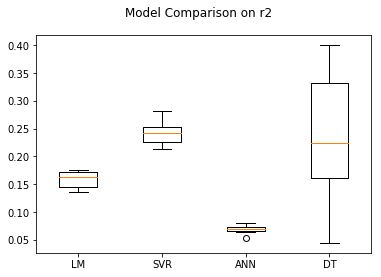

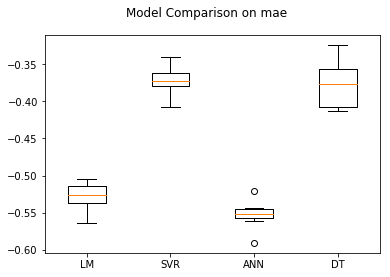

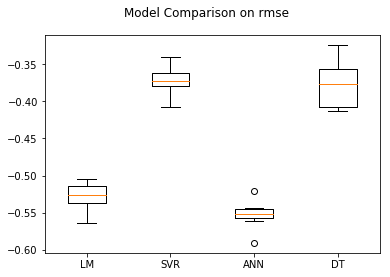

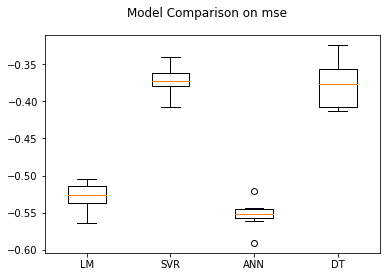

In [20]:
#INIT TODO: Change negative numbers into positive
generate_comparison(results_r2, 'r2')
generate_comparison(results_mae, 'mae')
generate_comparison(results_mae, 'rmse')
generate_comparison(results_mae, 'mse')

In [21]:
# Ensemble Methods

# --- Averaging Methods ---
# Voting (ANNs, CART, SVR, LR)
vote_models = []
vote = VotingRegressor(single_models)
vote_models.append(('VOTE', vote))
results_vote_r2 = cross_validate_score(vote_models, 'r2')
results_vote_rmse = cross_validate_score(vote_models, 'rmse')
results_vote_mse = cross_validate_score(vote_models, 'mse')
results_vote_mae = cross_validate_score(vote_models, 'mae')

r2: VOTE: 0.356247 (0.022391)
rmse: VOTE: 0.801191 (0.060421)
mse: VOTE: -0.640052 (0.059364)
mae: VOTE: -0.400780 (0.015337)


In [22]:
results_vote = {}
results_vote['R2'] = results_vote_r2
results_vote['RMSE'] = results_vote_rmse
results_vote['MSE'] = results_vote_mse
results_vote['MAE'] = results_vote_mae

In [23]:
# --- Averaging ---
# Bagging (ANN, LM, SVR, CART)
# Voting
# Random Forest Trees (Decision Trees)
# --- Boosting ---
# Gradient Boosting Machines

bagging_models = []
bagging_models.append(('LM', BaggingRegressor(lm)))
bagging_models.append(('SVR', BaggingRegressor(svr)))
bagging_models.append(('DT', BaggingRegressor(dt)))
bagging_models.append(('ANN', BaggingRegressor(ann)))

# Bagging
results_bagging_r2 = cross_validate_score(bagging_models, 'r2')
results_bagging_mse = cross_validate_score(bagging_models, 'mse')
results_bagging_rmse = cross_validate_score(bagging_models, 'rmse')
results_bagging_mae = cross_validate_score(bagging_models, 'mae')

# GMB & RFG (Boosting & Averaging)
results_ensemble_r2 = cross_validate_score(ensemble_models, 'r2')
results_ensemble_mse = cross_validate_score(ensemble_models, 'mse')
results_ensemble_rmse = cross_validate_score(ensemble_models, 'rmse')
results_ensemble_mae = cross_validate_score(ensemble_models, 'mae')

r2: LM: 0.158078 (0.014294)
r2: SVR: 0.247608 (0.022322)
r2: DT: 0.535188 (0.028097)
r2: ANN: 0.074857 (0.007607)
mse: LM: -0.842134 (0.075541)
mse: SVR: -0.752159 (0.078046)
mse: DT: -0.472521 (0.039683)
mse: ANN: -0.924793 (0.081287)
rmse: LM: 0.917406 (0.075436)
rmse: SVR: 0.866712 (0.075992)
rmse: DT: 0.686926 (0.051817)
rmse: ANN: 0.962105 (0.080315)
mae: LM: -0.528672 (0.016820)
mae: SVR: -0.372332 (0.018068)
mae: DT: -0.329864 (0.014427)
mae: ANN: -0.555520 (0.016698)
r2: GMB: 0.307916 (0.016356)
r2: RFG: 0.569899 (0.029771)
mse: GMB: -0.691852 (0.059601)
mse: RFG: -0.429830 (0.044561)
rmse: GMB: 0.831776 (0.059601)
rmse: RFG: 0.655615 (0.044561)
mae: GMB: -0.453823 (0.014155)
mae: RFG: -0.314317 (0.015034)


Bagging all Single Models


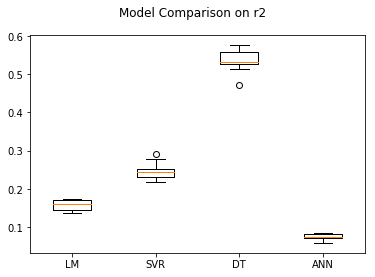

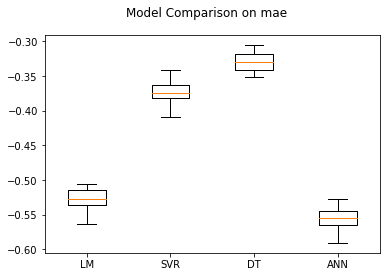

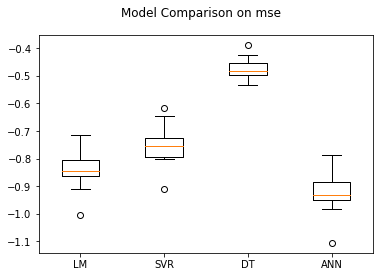

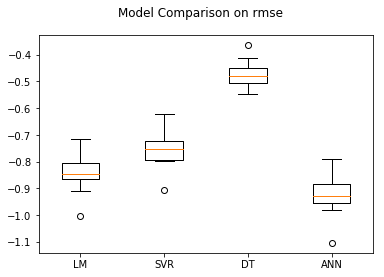

Boosting vs Averaging Technique


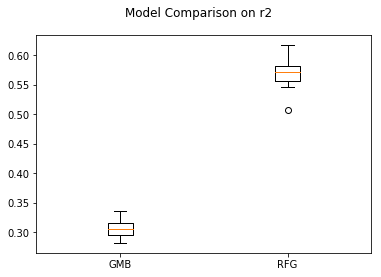

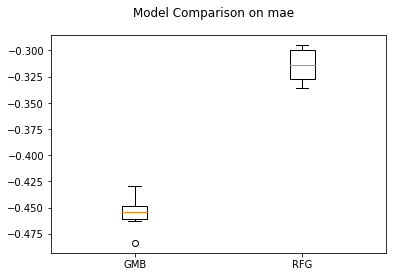

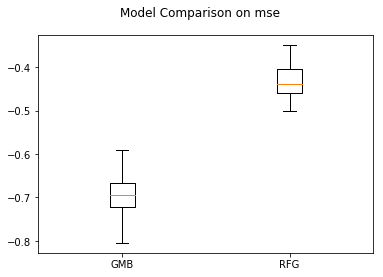

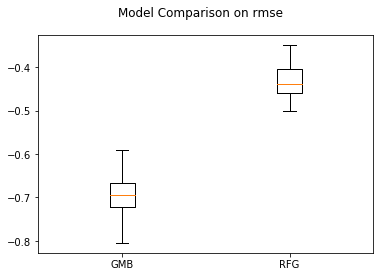

Voting Results


In [24]:
print("Bagging all Single Models")
generate_comparison(results_bagging_r2, 'r2')
generate_comparison(results_bagging_mae, 'mae')
generate_comparison(results_bagging_mse, 'mse')
generate_comparison(results_bagging_rmse, 'rmse')
#RFG and GMB
print("Boosting vs Averaging Technique")
generate_comparison(results_ensemble_r2, 'r2')
generate_comparison(results_ensemble_mae, 'mae')
generate_comparison(results_ensemble_mse, 'mse')
generate_comparison(results_ensemble_rmse, 'rmse')

print("Voting Results")


In [76]:
# Train Bagging model with RFG, as Bagging on single models, and RFG outperform single models on its own, and GMB and voting.

#Bagging RF vs DT
baggingdt_rf = []
baggingdt_rf.append(('RF', rf))
baggingdt_rf.append(('BAG-DT', BaggingRegressor(dt, bootstrap_features=True)))
baggingdt_rf.append(('DT', dt))
baggingdt_rf.append(('SVR', svr))
baggingdt_rf.append(('BAG-SVR', BaggingRegressor(svr)))
results_baggingdt_rf = cross_validate_score(baggingdt_rf, 'r2')

r2: RF: 0.552027 (0.026192)
r2: BAG-DT: 0.518246 (0.027986)
r2: DT: 0.229658 (0.091096)
r2: SVR: 0.243712 (0.021276)
r2: BAG-SVR: 0.247296 (0.020023)


In [77]:
results_baggingdt_rf

{'RF': array([0.54012348, 0.5490645 , 0.52253578, 0.56694671, 0.59286722,
        0.56121494, 0.57257906, 0.55006414, 0.49589163, 0.56898374]),
 'BAG-DT': array([0.49059571, 0.54002574, 0.4961747 , 0.54326532, 0.5290563 ,
        0.52815037, 0.54584897, 0.54431468, 0.45731403, 0.50770921]),
 'DT': array([0.15400841, 0.08837076, 0.21407251, 0.14314996, 0.4149081 ,
        0.25267962, 0.29973796, 0.28220438, 0.16463427, 0.28281362]),
 'SVR': array([0.24820243, 0.21993664, 0.21392309, 0.27503247, 0.25541522,
        0.24031769, 0.28127014, 0.23891189, 0.24251792, 0.22159007]),
 'BAG-SVR': array([0.25460057, 0.22093888, 0.22039115, 0.27658012, 0.2591766 ,
        0.24595939, 0.2805477 , 0.23937738, 0.24728218, 0.22810373])}

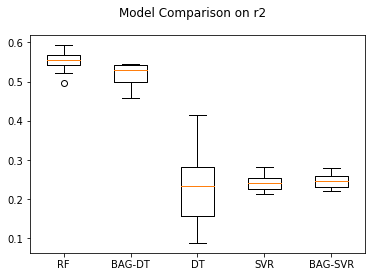

In [78]:
generate_comparison(results_baggingdt_rf, 'r2')

In [80]:
# Train Model with Testing Set 
# RF Train on test Data
x_test_scaled = independent_scaler.fit_transform(X_test)
y_test_scaled = target_scaler.fit_transform(y_test.reshape(-1, 1))

X_test_scaled_DF = pd.DataFrame(x_test_scaled, columns=x_train_DF.columns)
Y_test_scaled_DF = pd.DataFrame(y_test_scaled, columns=y_train_DF.columns)

model = []
model.append(('RF', rf))
results_randomforest_r2 = cross_validate_score_test(model, 'r2', X_test_scaled_DF, Y_test_scaled_DF)
results_randomforest_rmse = cross_validate_score_test(model, 'rmse', X_test_scaled_DF, Y_test_scaled_DF)
results_randomforest_mse = cross_validate_score_test(model, 'mse', X_test_scaled_DF, Y_test_scaled_DF)
results_randomforest_mae = cross_validate_score_test(model, 'mae', X_test_scaled_DF, Y_test_scaled_DF)

r2: RF: 0.379055 (0.055318)
rmse: RF: 0.780303 (0.073717)
mse: RF: -0.617828 (0.068979)
mae: RF: -0.398413 (0.029511)


In [81]:
model = rf
model.fit(x_train_scaled, y_train_scaled.ravel())

RandomForestRegressor(n_estimators=20)

In [82]:
predY = model.predict(x_test_scaled)

In [83]:
from IPython.display import FileLink, FileLinks
import numpy as np
#Unscale results, and export as CSV
predY_DF = pd.DataFrame(predY)
predY_unscaled = target_scaler.inverse_transform(predY_DF)
predY_DF_unscaled = pd.DataFrame(predY_unscaled)
predY_DF_unscaled
csv = predY_DF_unscaled.to_csv('predictedY.csv', index=False)

In [84]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

r2 = r2_score(y_test_scaled, predY)
mse = mean_squared_error(y_test_scaled, predY)
mae = mean_absolute_error(y_test_scaled, predY)
rmse = math.sqrt(mean_squared_error(y_test_scaled, predY))

In [85]:
print("R2:", r2)
print("MSE:", mse)
print("MAE:", mae)
print("RMSE:", rmse)

R2: 0.5522775558899713
MSE: 0.44772244411002876
MAE: 0.32314647335032776
RMSE: 0.6691206498906074
